In [1]:
%matplotlib inline

In [2]:
import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations, test_samples, X=None, Y=None, Z=None, src_si_len=0, \
                 tgt_si_len=0, lang_pair_si_len=0, src_index=None, tgt_index=None, model=None, num_running=0):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)                  : src-tgt language rating matrix
        - K (int)                      : number of latent dimensions
        - alpha (float)                : learning rate
        - beta (float)                 : regularization parameter
        - X (dict)                     : source language side information
        - Y (dict)                     : target language side information
        - Z (dict)                     : language pair side information
        - src_si_len(int)              : source language side information length
        - tgt_si_len(int)              : target language side information length
        - lang_pair_si_len(int)        : language pair side information length
        """

        self.R = np.array(R)
        self.Prediction = deepcopy(self.R)
        self.src_langs = R.index.tolist()
        self.tgt_langs = R.columns.tolist()
        self.num_src, self.num_tgt = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.X = X
        self.Y = Y
        self.Z = Z
        self.src_si_len = src_si_len
        self.tgt_si_len = tgt_si_len
        self.lang_pair_si_len = lang_pair_si_len
        self.test_samples = test_samples
        self.src_index=src_index 
        self.tgt_index=tgt_index
        self.model=model
        self.num_running = num_running
        self.score_dict = {'BLEU': "WIKI-MT", "Muse": "BLI-Muse", "Vecmap": "BLI-Vecmap"}
        self.traing_error_log=[]
        self.test_error_log=[]
        

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_src, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_tgt, self.K))

        # Initialize side information's parameter if necesary
        if self.X and self.src_si_len:
            self.A = np.random.normal(scale = 1./self.src_si_len, size=self.src_si_len)
        if self.Y and self.tgt_si_len:
            self.B = np.random.normal(scale = 1./self.tgt_si_len, size=self.tgt_si_len)
        if self.Z and self.lang_pair_si_len:
            self.C = np.random.normal(scale = 1./self.lang_pair_si_len, size=self.lang_pair_si_len)
        
        # Initialize the biases
        # the biases of users and items are initilized as 0
        # the bias of rating is initilized as mean value
        self.b_u = np.zeros(self.num_src)
        self.b_i = np.zeros(self.num_tgt)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples (where rating > 0)
        self.samples = []
        for i in range(self.num_src):
            for j in range(self.num_tgt):
                if self.R[i,j] > 0:
                    cur_tuple = [i, j, self.R[i, j]]
                    src_lang = self.src_langs[i]
                    tgt_lang = self.tgt_langs[j]
                    if self.X:
                        if src_lang in self.X.keys():
                            cur_tuple.append(self.X[src_lang])
                        else:
                            raise KeyError
                    if self.Y:
                        if tgt_lang in self.Y.keys():
                            cur_tuple.append(self.Y[src_lang])
                        else:
                            raise KeyError
                    if self.Z:
                        if src_lang + "_" + tgt_lang in self.Z.keys():
                            cur_tuple.append(self.Z[src_lang + "_" + tgt_lang])
                        else:
                            raise KeyError
                    self.samples.append(tuple(cur_tuple))

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            # shuffle training samples
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 100 == 0:
                self.traing_error_log.append((i, mse))
                test_mse = self.evaluate_testing(self.test_samples, self.src_index, self.tgt_index, self.model)
                self.test_error_log.append((i, test_mse))
#                 print("\t\tIteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
#         predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x][y] - self.Prediction[x][y], 2)
        return np.sqrt(error / len(xs))

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for sample in self.samples:
            i, j, r = sample[0], sample[1], sample[2]
            # Computer prediction and error
            prediction = self.get_rating(sample)
            self.Prediction[i][j] = prediction
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])
            
            # Update side information parameter if necessary
            cur_index = 3
            if self.X:
                x = np.array(sample[cur_index], dtype=np.float64)
                cur_index += 1
                self.A += self.alpha * (e * x - self.beta * self.A)
            if self.Y:
                y = np.array(sample[cur_index], dtype=np.float64)
                cur_index += 1
                self.B += self.alpha * (e * y - self.beta * self.B)
            if self.Z:
                z = np.array(sample[cur_index], dtype=np.float64)
                self.C += self.alpha * (e * z - self.beta * self.C)
                

    def get_rating(self, sample):
        """
        Get the predicted rating of sample
        """
        i, j, r = sample[0], sample[1], sample[2]
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        cur_index = 3
        if self.X:
            x = sample[cur_index]
            cur_index += 1
            prediction += self.A.dot(x.T)
        if self.Y:
            y = sample[cur_index]
            cur_index += 1
            prediction += self.B.dot(y.T)
        if self.Z:
            z = sample[cur_index]
            prediction += self.C.dot(z.T)
        return prediction
    
    def evaluate_testing(self, test_data, src_index_name, tgt_index_name, score_index_name):
        """
        Predict the score for testing data
        """ 
        rmse = 0.0
        for record in test_data.iterrows():
            record = record[1]
            src_lang = record[src_index_name]
            tgt_lang = record[tgt_index_name]
            src_lang_index = self.src_langs.index(src_lang)
            tgt_lang_index = self.tgt_langs.index(tgt_lang)
            score = record[score_index_name]
            cur_tuple = [src_lang_index, tgt_lang_index, score]
            if self.X:
                if src_lang in self.X.keys():
                    cur_tuple.append(self.X[src_lang])
                else:
                    raise KeyError
            if self.Y:
                if tgt_lang in self.Y.keys():
                    cur_tuple.append(self.Y[src_lang])
                else:
                    raise KeyError
            if self.Z:
                if src_lang + "_" + tgt_lang in self.Z.keys():
                    cur_tuple.append(self.Z[src_lang + "_" + tgt_lang])
                else:
                    raise KeyError
            prediction = self.get_rating(tuple(cur_tuple))
            rmse += (prediction - score) * (prediction - score)
        return np.sqrt(rmse / len(test_data))
        

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P, Q, A, B, and C
        """
        res = deepcopy(self.R)
        for i in range(self.num_src):
            for j in range(self.num_tgt):
                src_lang = self.src_langs[i]
                tgt_lang = self.tgt_langs[j]
                res[i][j] = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
                if self.X and src_lang in self.X.keys():
                    x = self.X[src_lang]
                    res[i][j] += self.A.dot(x.T)
                if self.Y and tgt_lang in self.Y.keys():
                    y = self.X[tgt_lang]
                    res[i][j] += self.A.dot(x.T)
                if self.Z and src_lang + "_" + tgt_lang in self.Z.keys():
                    z = self.X[src_lang + "_" + tgt_lang]
                    res[i][j] += self.A.dot(x.T)
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
    
    def draw_error_curve(self, i):
        import matplotlib.pyplot as plt
        import numpy as np
        iters = []
        train_loss = []
        test_loss = []
        for item in self.traing_error_log:
            iters.append(item[0])
            train_loss.append(item[1])
        for item in self.test_error_log:
            test_loss.append(item[1])

        plt.plot(iters, train_loss, 'b', label='train loss')#'b'指：color='blue'
        plt.plot(iters, test_loss, 'r', label='test loss')#'r'指：color='red'

        plt.legend()  #显示上面的label
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        title = self.score_dict[self.model] + "_" + str(self.num_running+1) + "_Fold" + str(i+1)
        plt.title(title) 
        plt.savefig("../result/within_single_si/" + self.score_dict[self.model] + "/fold" + str(i+1) + "/" + title + ".png")

        #plt.ylim(-1,1)#仅设置y轴坐标范围
        plt.show()

        

Represent the two tasks above as matrices (BLEU scores for Wiki-MT and Accuracy for BLI) 

In [3]:
import pandas as pd
import numpy as np
np.random.seed(2021)

In [4]:
from copy import deepcopy
import pandas as pd
import random as rd

def split_k_fold_data(file_dir, score_index_name, src_index_name, tgt_index_name, k=5):
    data = pd.read_csv(file_dir)
    
    # shuffle
    data = data.sample(frac=1)
    
    # generate score matrix
    src_langs = data[src_index_name].unique()
    tgt_langs = data[tgt_index_name].unique()
    score_matrix = pd.DataFrame(index = src_langs, columns = tgt_langs)
    
    # eliminate empty rows and columns
    data = data.dropna(axis=1, how="all")
    data = data.dropna(axis=0, how="all")
    
    # K fold split
    k_fold_data = {}
    models = list(score_index_name)
    lens= len(data)
    
    for i, model in enumerate(models):
        ex_per_fold = int(np.ceil(lens / k))
        for j in range(k):
            start = ex_per_fold * j
            end = ex_per_fold * (j + 1)
            if j == 0:
                k_fold_data[model] = {"train": [], "test": []}
            k_fold_data[model]["train"].append(pd.concat([data.iloc[:start, :], data.iloc[end:, :]], axis=0))
            k_fold_data[model]["test"].append(data.iloc[start:end, :])
    return k_fold_data, score_matrix

def generate_score_matrix(train_data, src_index_name, tgt_index_name, score_index_name, origin_score_matrix):    
    score_matrix = deepcopy(origin_score_matrix)
    
    for record in train_data.iterrows():
        record = record[1]
        src_lang = record[src_index_name]
        tgt_lang = record[tgt_index_name]
        score = record[score_index_name]
        score_matrix.loc[src_lang, tgt_lang] = score
#         score_matrix[src_lang][tgt_lang] = score
    score_matrix.fillna(0, inplace=True)
    return score_matrix

def get_rmse(valid_data, model, src_index_name, tgt_index_name, score_matrix, train_matrix):
    rmse = 0.0
    src_langs = train_matrix.index.tolist()
    tgt_langs = train_matrix.columns.tolist()
    for cur_valid_data in valid_data.iterrows():
        cur_valid_data = cur_valid_data[1]
        src_lang, tgt_lang, score = cur_valid_data[src_index_name], cur_valid_data[tgt_index_name], cur_valid_data[model]
        src_idx = src_langs.index(src_lang)
        tgt_idx = tgt_langs.index(tgt_lang)
        prediction = score_matrix[src_idx][tgt_idx]
        rmse += (prediction - score) * (prediction - score)
    return np.sqrt(rmse / len(valid_data))

def get_result(alpha, beta, data_dir, scores, src_index, tgt_index, k, num_running, src_lang_side_info=None, \
               tgt_lang_side_info=None, lang_pair_side_info=None, src_si_len=0, tgt_si_len=0, \
               lang_pair_si_len=0):
    all_running_rmse = 0.0
    for nr in range(num_running):
        print("num running: " + str(nr+1))
        data, langs_matrix = split_k_fold_data(data_dir, scores, src_index, tgt_index, k)
        
        src_langs = langs_matrix.index.tolist()
        tgt_langs = langs_matrix.columns.tolist()
        
        res = {}
        for model in scores:
            print("-"*40)
            print(model)
            total_rmse = 0.0
            for i in range(k):
                print("\tFold {}: ".format(i+1))
                train_data, test_data = data[model]["train"][i], data[model]["test"][i]
                train_matrix = generate_score_matrix(train_data, src_index, tgt_index, model, langs_matrix)
                mf = MF(train_matrix, K=2, alpha=alpha, beta=beta, iterations=2000, test_samples=test_data, X=src_lang_side_info, \
                        Y=tgt_lang_side_info, Z=lang_pair_side_info, src_si_len=src_si_len, tgt_si_len=tgt_si_len, \
                        lang_pair_si_len=lang_pair_si_len, src_index=src_index, tgt_index=tgt_index, model=model, \
                       num_running=nr)
                trainging_log = mf.train()
#                 predictions = mf.full_matrix()
#                 cur_rmse = get_rmse(test_data, model, src_index, tgt_index, predictions, train_matrix)
                cur_rmse = mf.evaluate_testing(test_data, src_index, tgt_index, model)
                mf.draw_error_curve(i)
                total_rmse += cur_rmse
                print("\t\trmse is {}.".format(cur_rmse))
                print("*" * 20)
                
            average_rmse = total_rmse / k
            print("average rmse: " + str(average_rmse))
            res[model] = average_rmse
        res_rmse = 0.0
        for key, value in res.items():
            res_rmse += value
        all_running_rmse += res_rmse / len(scores)
    return all_running_rmse / num_running

def get_language_pair_side_info(data_dir, side_info_features, src_lang_name, tgt_lang_name):
    data = pd.read_csv(data_dir)
    side_dict = {}
    for record in data.iterrows():
        record = record[1]
        src_lang = record[src_lang_name]
        tgt_lang = record[tgt_lang_name]
        side_dict[src_lang + "_" + tgt_lang] = record[side_info_features].values
    return side_dict

def get_language_side_information(data_dir, src_lang_name, tgt_lang_name):
    
    data = pd.read_csv(data_dir)
    side_dict = {}
    src_langs = set()
    tgt_langs = set()
    
    for record in data.iterrows():
        record = record[1]
        src_lang = record[src_lang_name]
        tgt_lang = record[tgt_lang_name]
        src_langs.add(src_lang)
        tgt_langs.add(tgt_lang)
        
    src_langs = list(src_langs)
    tgt_langs = list(tgt_langs)
        
    return languages_to_features(src_langs), languages_to_features(tgt_langs)

def languages_to_features(languages_list):
    from sklearn.decomposition import PCA
    import lang2vec.lang2vec as l2v
    features_list = ["syntax_knn", "phonology_knn", "inventory_knn"]
    features = l2v.get_features(languages_list, features_list)
    
    features_matrix = []
    for language in languages_list:
        features_matrix.append(features[language])
        
    pca = PCA(n_components=6)   
    pca_features_matrix = pca.fit_transform(features_matrix)
    res = {}
    
    for i, language in enumerate(languages_list):
        res[languages_list[i]] = pca_features_matrix[i]
    return res

num running: 1
----------------------------------------
BLEU
	Fold 1: 


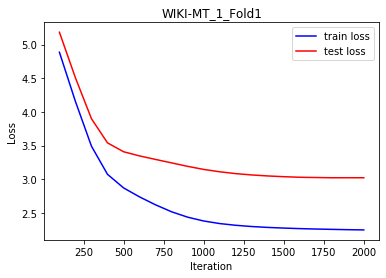

		rmse is 3.020953425495983.
********************
	Fold 2: 


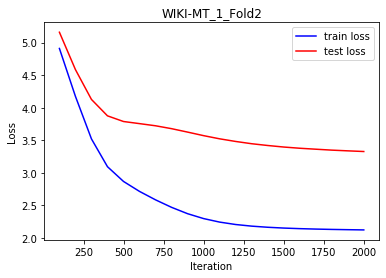

		rmse is 3.3267647434290937.
********************
	Fold 3: 


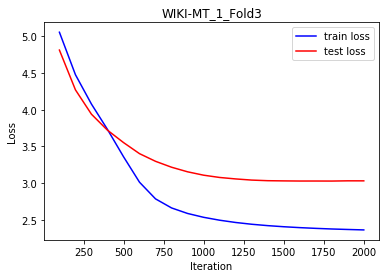

		rmse is 3.030483824669507.
********************
	Fold 4: 


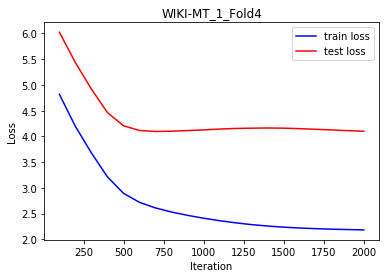

		rmse is 4.100395260966355.
********************
	Fold 5: 


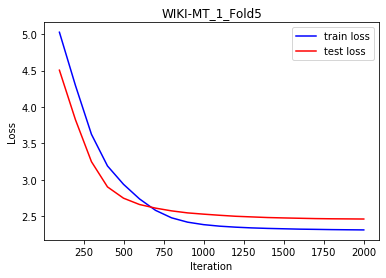

		rmse is 2.4627342124731593.
********************
average rmse: 3.1882662934068193
num running: 2
----------------------------------------
BLEU
	Fold 1: 


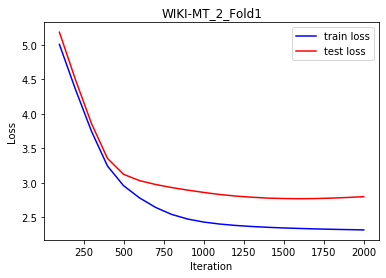

		rmse is 2.7981796277883797.
********************
	Fold 2: 


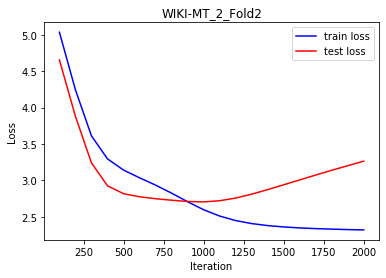

		rmse is 3.2632512551548487.
********************
	Fold 3: 


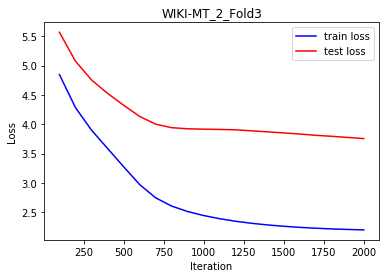

		rmse is 3.7561206446658932.
********************
	Fold 4: 


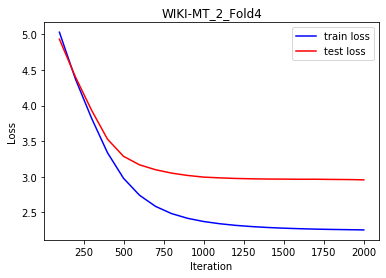

		rmse is 2.956397330800651.
********************
	Fold 5: 


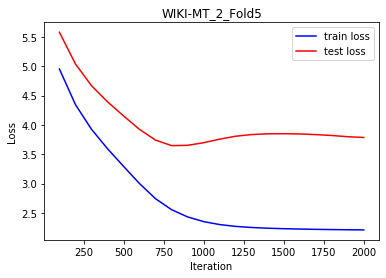

		rmse is 3.7857045300048604.
********************
average rmse: 3.311930677682927
num running: 3
----------------------------------------
BLEU
	Fold 1: 


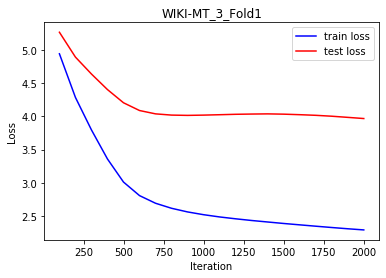

		rmse is 3.9668594205393943.
********************
	Fold 2: 


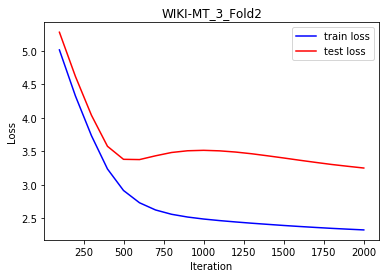

		rmse is 3.2518525672203484.
********************
	Fold 3: 


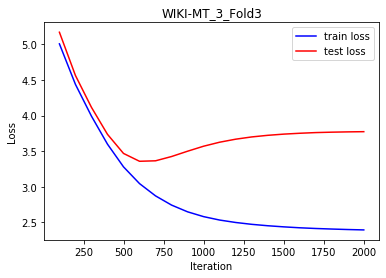

		rmse is 3.77329589067507.
********************
	Fold 4: 


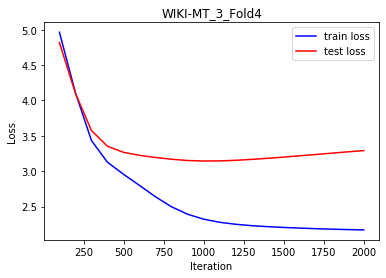

		rmse is 3.290979111798144.
********************
	Fold 5: 


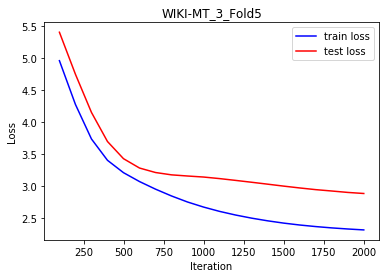

		rmse is 2.8846697929998473.
********************
average rmse: 3.4335313566465606
num running: 4
----------------------------------------
BLEU
	Fold 1: 


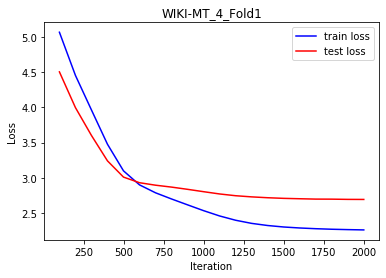

		rmse is 2.6937512327408806.
********************
	Fold 2: 


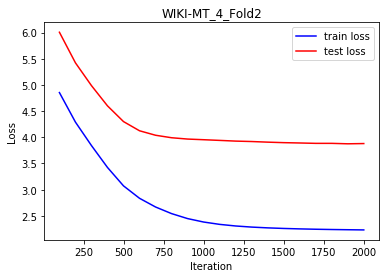

		rmse is 3.880683186376358.
********************
	Fold 3: 


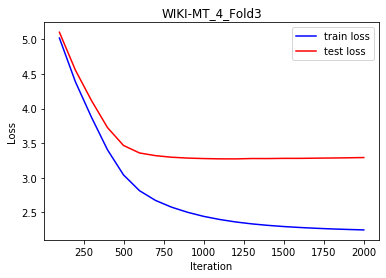

		rmse is 3.2936324082493686.
********************
	Fold 4: 


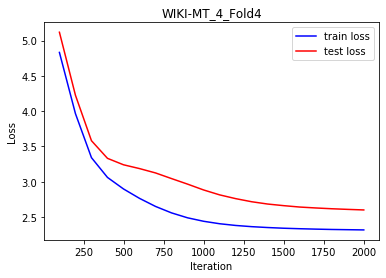

		rmse is 2.599257522268081.
********************
	Fold 5: 


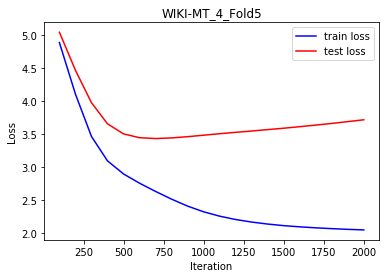

		rmse is 3.7199333119534352.
********************
average rmse: 3.2374515323176247
num running: 5
----------------------------------------
BLEU
	Fold 1: 


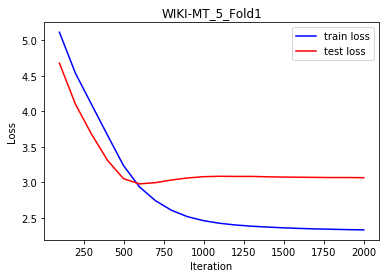

		rmse is 3.0673900527956928.
********************
	Fold 2: 


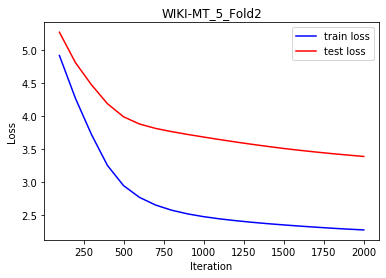

		rmse is 3.392040994621711.
********************
	Fold 3: 


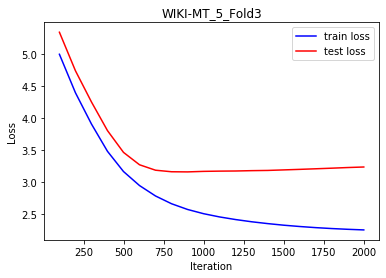

		rmse is 3.2397649672028077.
********************
	Fold 4: 


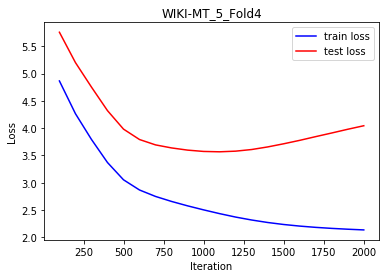

		rmse is 4.04420758988948.
********************
	Fold 5: 


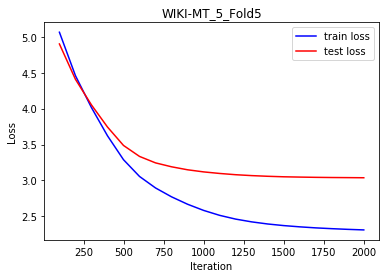

		rmse is 3.0380323766206945.
********************
average rmse: 3.356287196226077
num running: 6
----------------------------------------
BLEU
	Fold 1: 


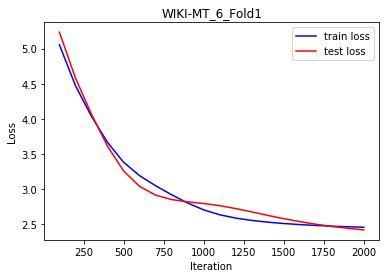

		rmse is 2.416101157686642.
********************
	Fold 2: 


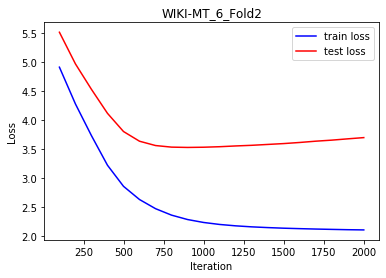

		rmse is 3.7016292212789836.
********************
	Fold 3: 


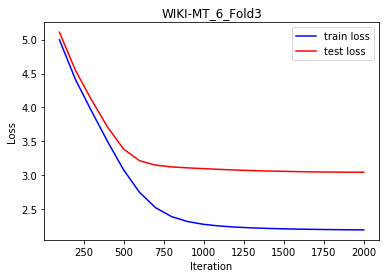

		rmse is 3.0450103803546593.
********************
	Fold 4: 


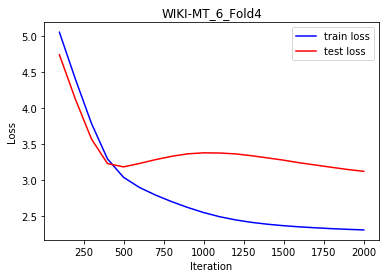

		rmse is 3.1248616000488814.
********************
	Fold 5: 


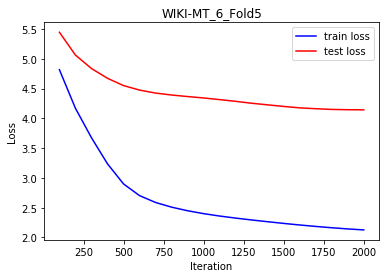

		rmse is 4.144467479766577.
********************
average rmse: 3.2864139678271487
num running: 7
----------------------------------------
BLEU
	Fold 1: 


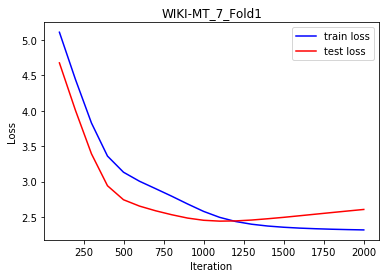

		rmse is 2.607810816981734.
********************
	Fold 2: 


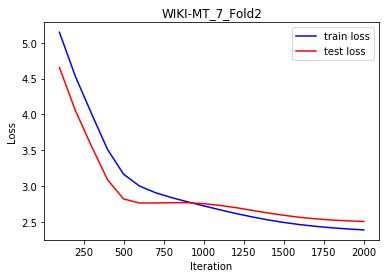

		rmse is 2.5054496019492367.
********************
	Fold 3: 


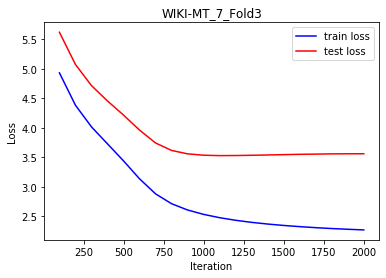

		rmse is 3.56137586102681.
********************
	Fold 4: 


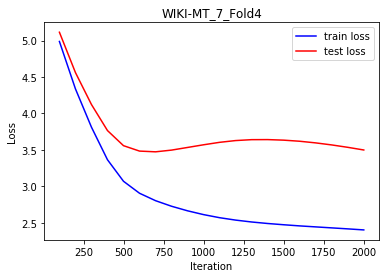

		rmse is 3.498707121116611.
********************
	Fold 5: 


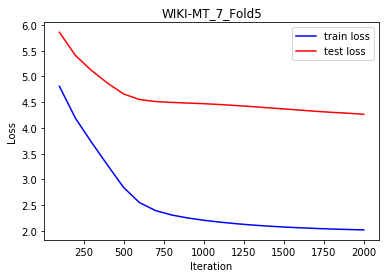

		rmse is 4.264709286053476.
********************
average rmse: 3.2876105374255737
num running: 8
----------------------------------------
BLEU
	Fold 1: 


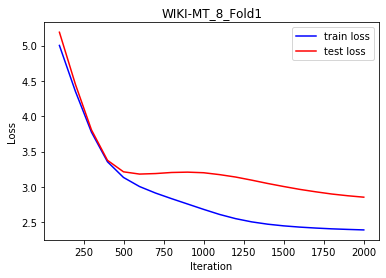

		rmse is 2.8554271126945574.
********************
	Fold 2: 


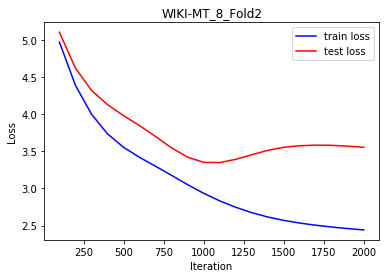

		rmse is 3.553626184554721.
********************
	Fold 3: 


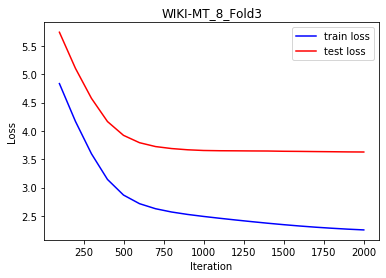

		rmse is 3.628114509220212.
********************
	Fold 4: 


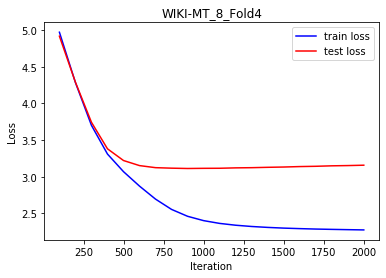

		rmse is 3.1562472135000066.
********************
	Fold 5: 


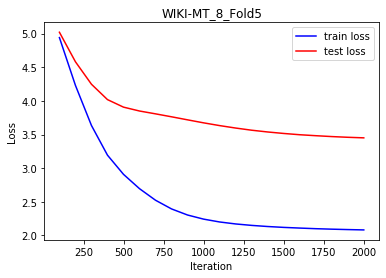

		rmse is 3.4507765681959266.
********************
average rmse: 3.3288383176330845
num running: 9
----------------------------------------
BLEU
	Fold 1: 


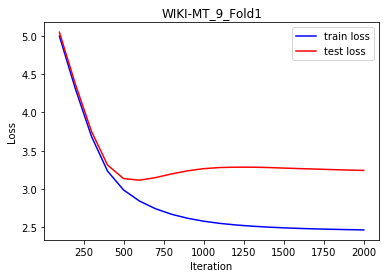

		rmse is 3.2433758250764897.
********************
	Fold 2: 


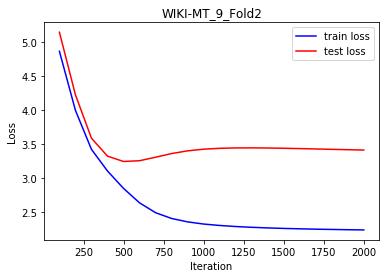

		rmse is 3.410544488170894.
********************
	Fold 3: 


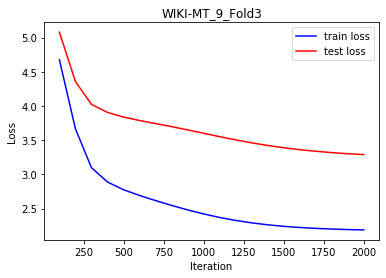

		rmse is 3.2897194901423483.
********************
	Fold 4: 


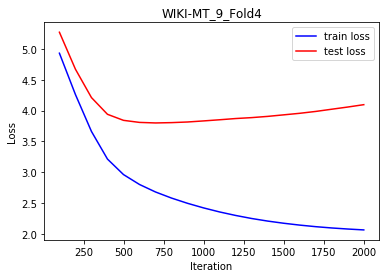

		rmse is 4.096124234505675.
********************
	Fold 5: 


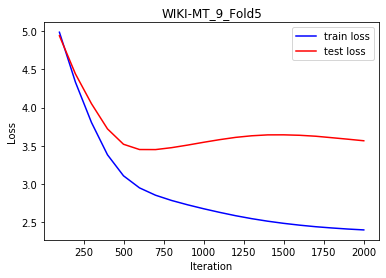

		rmse is 3.5653562906549037.
********************
average rmse: 3.521024065710062
num running: 10
----------------------------------------
BLEU
	Fold 1: 


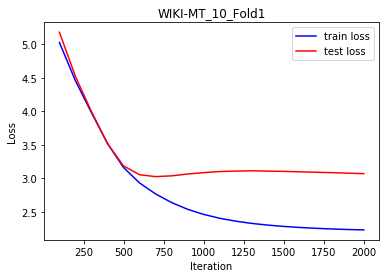

		rmse is 3.0709839939463826.
********************
	Fold 2: 


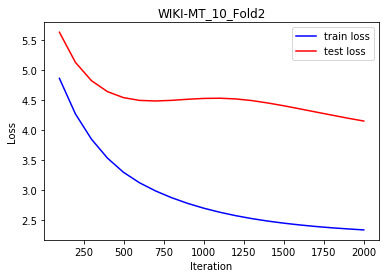

		rmse is 4.1534201816951954.
********************
	Fold 3: 


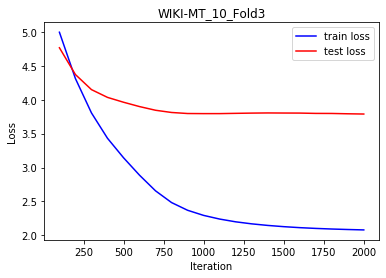

		rmse is 3.78890471116356.
********************
	Fold 4: 


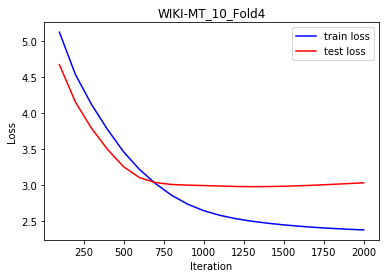

		rmse is 3.0285325960073473.
********************
	Fold 5: 


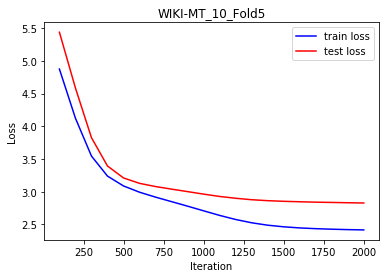

		rmse is 2.8275082734338524.
********************
average rmse: 3.3738699512492674
num running: 1
----------------------------------------
Muse
	Fold 1: 


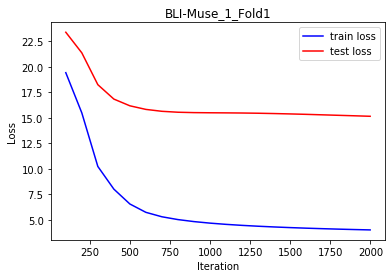

		rmse is 15.148209574532624.
********************
	Fold 2: 


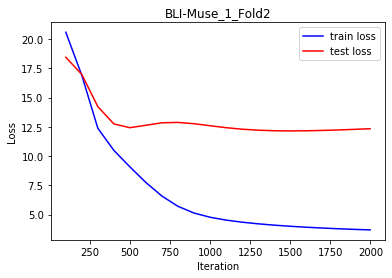

		rmse is 12.342294426913233.
********************
	Fold 3: 


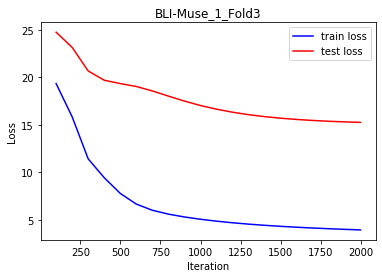

		rmse is 15.260329217564651.
********************
	Fold 4: 


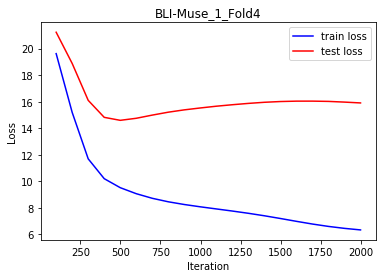

		rmse is 15.905177245520305.
********************
	Fold 5: 


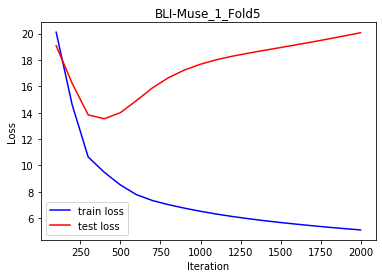

		rmse is 20.065895201263004.
********************
average rmse: 15.744381133158765
----------------------------------------
Vecmap
	Fold 1: 


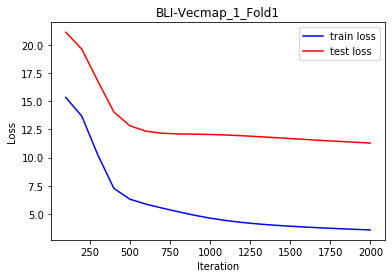

		rmse is 11.286722114613614.
********************
	Fold 2: 


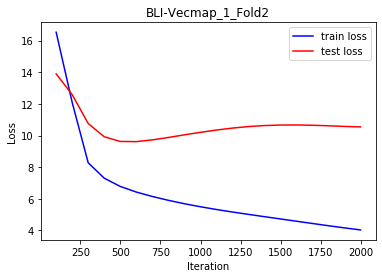

		rmse is 10.54406472381777.
********************
	Fold 3: 


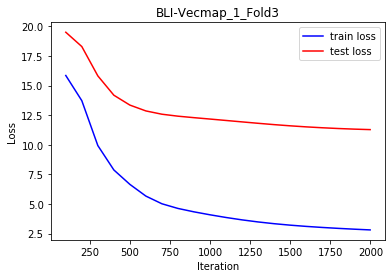

		rmse is 11.285951757609526.
********************
	Fold 4: 


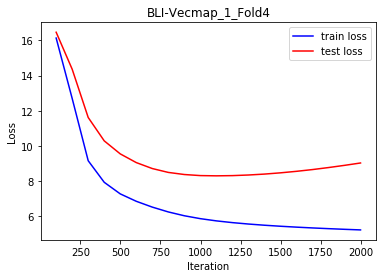

		rmse is 9.029251279456705.
********************
	Fold 5: 


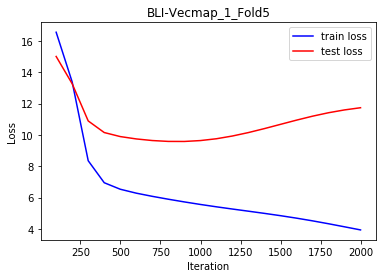

		rmse is 11.731779487153068.
********************
average rmse: 10.775553872530137
num running: 2
----------------------------------------
Muse
	Fold 1: 


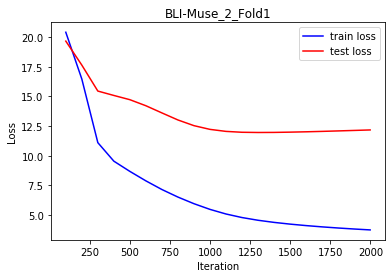

		rmse is 12.170865779787546.
********************
	Fold 2: 


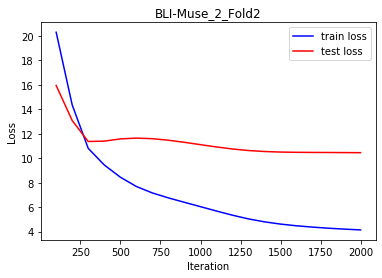

		rmse is 10.45501427186932.
********************
	Fold 3: 


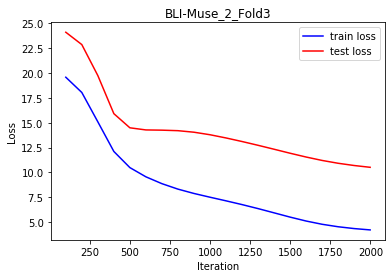

		rmse is 10.513123741876843.
********************
	Fold 4: 


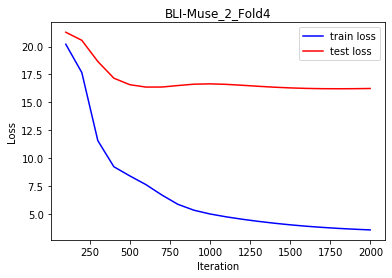

		rmse is 16.242770066323583.
********************
	Fold 5: 


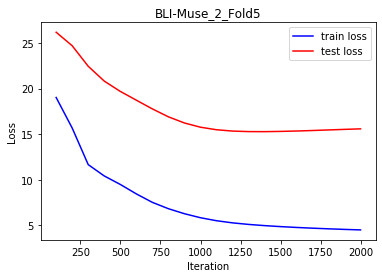

		rmse is 15.578835101205474.
********************
average rmse: 12.992121792212552
----------------------------------------
Vecmap
	Fold 1: 


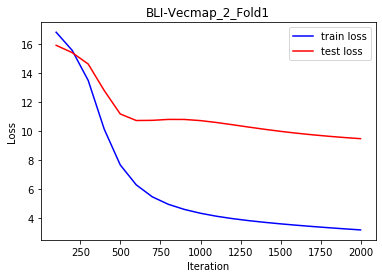

		rmse is 9.482951509460104.
********************
	Fold 2: 


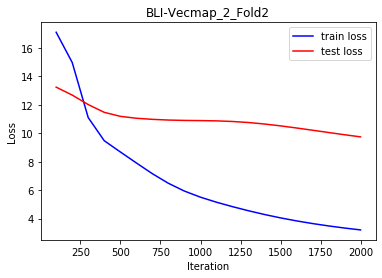

		rmse is 9.747907004741549.
********************
	Fold 3: 


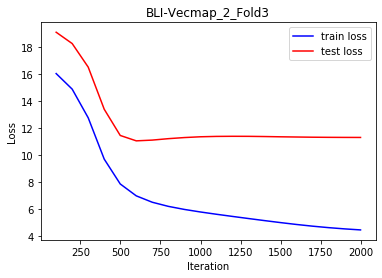

		rmse is 11.291914132037803.
********************
	Fold 4: 


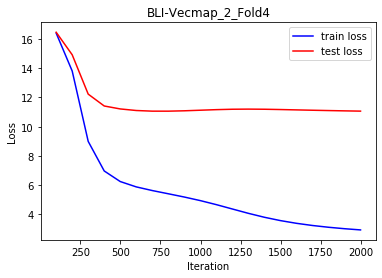

		rmse is 11.065506674266091.
********************
	Fold 5: 


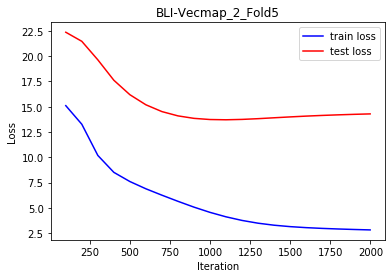

		rmse is 14.288697990002682.
********************
average rmse: 11.175395462101646
num running: 3
----------------------------------------
Muse
	Fold 1: 


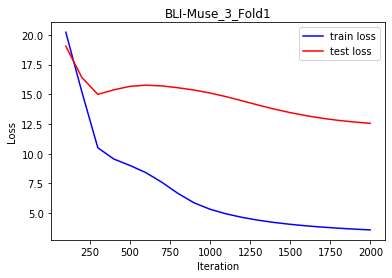

		rmse is 12.561037772069948.
********************
	Fold 2: 


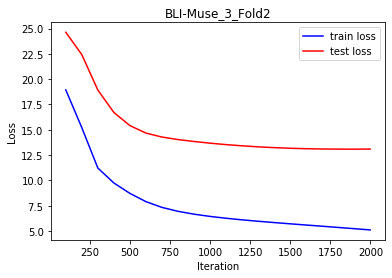

		rmse is 13.095354378343918.
********************
	Fold 3: 


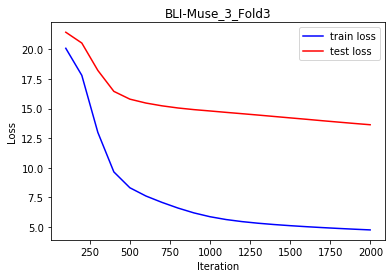

		rmse is 13.632883112893044.
********************
	Fold 4: 


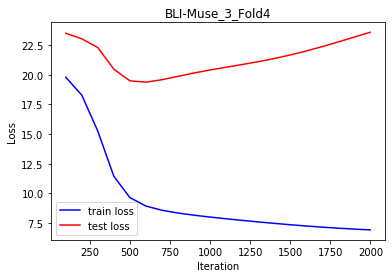

		rmse is 23.576935563591576.
********************
	Fold 5: 


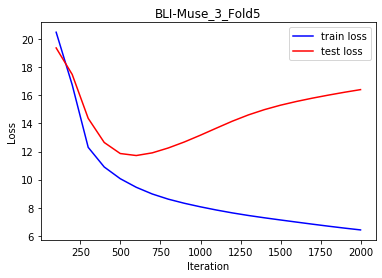

		rmse is 16.40470439271744.
********************
average rmse: 15.854183043923182
----------------------------------------
Vecmap
	Fold 1: 


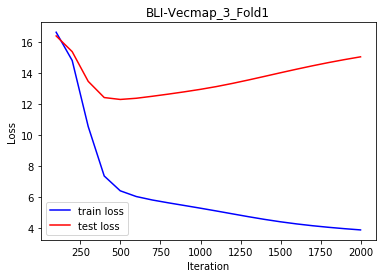

		rmse is 15.064088029553043.
********************
	Fold 2: 


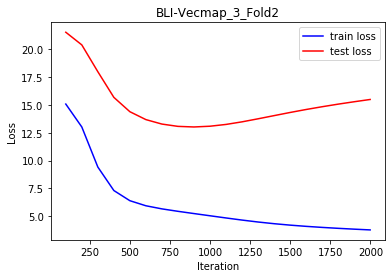

		rmse is 15.502604481318075.
********************
	Fold 3: 


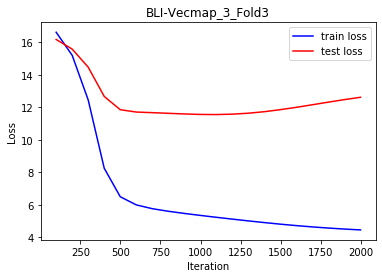

		rmse is 12.624244891182018.
********************
	Fold 4: 


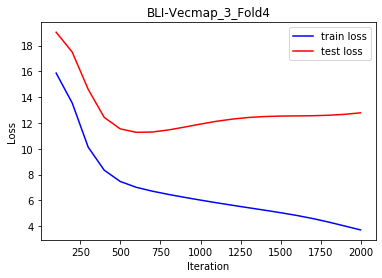

		rmse is 12.786411001225343.
********************
	Fold 5: 


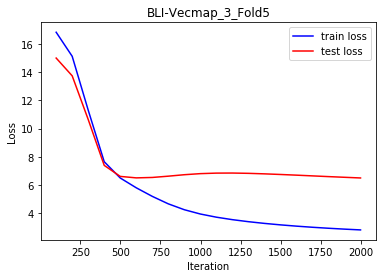

		rmse is 6.497745767918732.
********************
average rmse: 12.495018834239442
num running: 4
----------------------------------------
Muse
	Fold 1: 


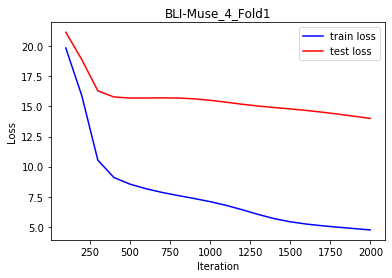

		rmse is 14.0067492143107.
********************
	Fold 2: 


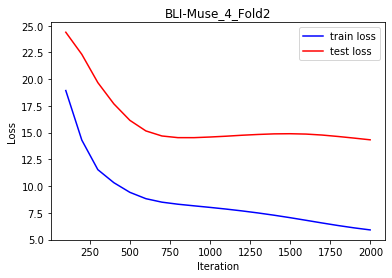

		rmse is 14.327042350708188.
********************
	Fold 3: 


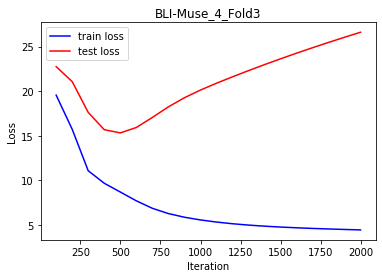

		rmse is 26.615570653790666.
********************
	Fold 4: 


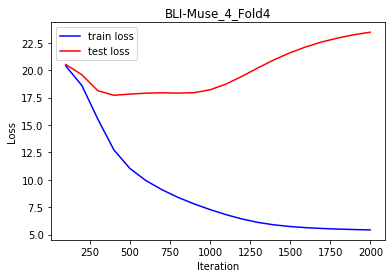

		rmse is 23.467855513410232.
********************
	Fold 5: 


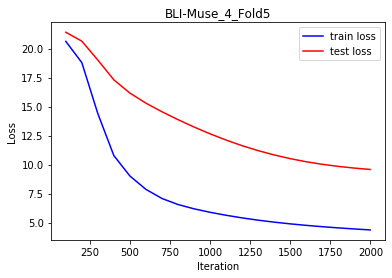

		rmse is 9.575368227923137.
********************
average rmse: 17.598517192028584
----------------------------------------
Vecmap
	Fold 1: 


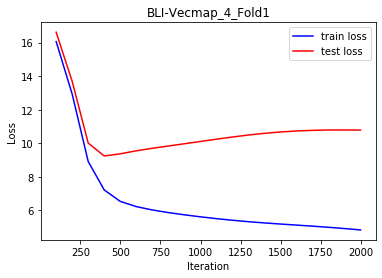

		rmse is 10.784570152332806.
********************
	Fold 2: 


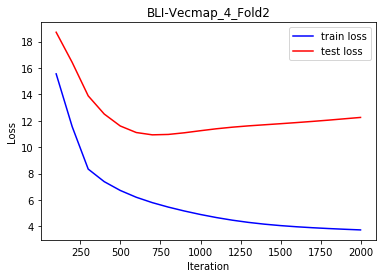

		rmse is 12.251666059079044.
********************
	Fold 3: 


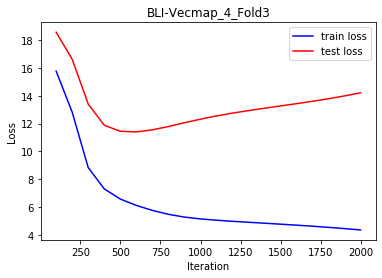

		rmse is 14.20807835054296.
********************
	Fold 4: 


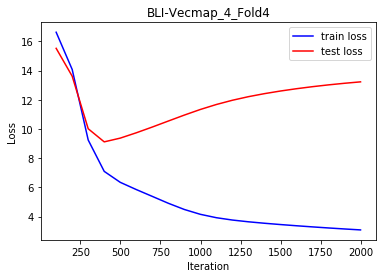

		rmse is 13.231397602899094.
********************
	Fold 5: 


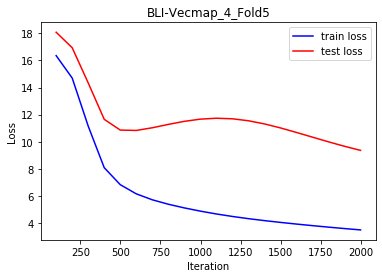

		rmse is 9.361262517168676.
********************
average rmse: 11.967394936404515
num running: 5
----------------------------------------
Muse
	Fold 1: 


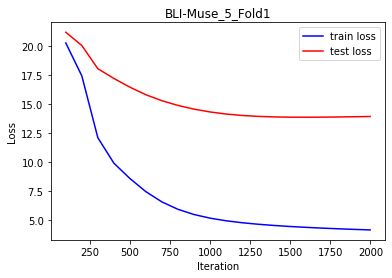

		rmse is 13.952347120948547.
********************
	Fold 2: 


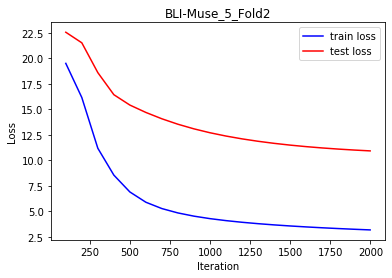

		rmse is 10.925836435350362.
********************
	Fold 3: 


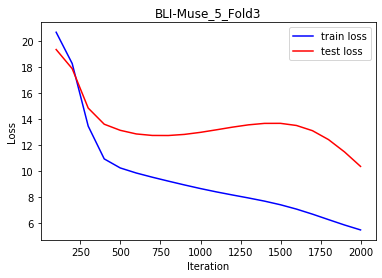

		rmse is 10.364819012283201.
********************
	Fold 4: 


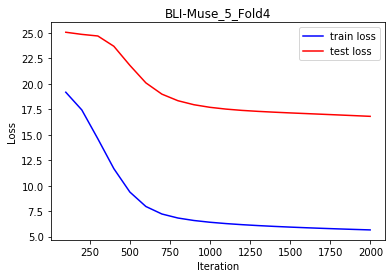

		rmse is 16.803738273096286.
********************
	Fold 5: 


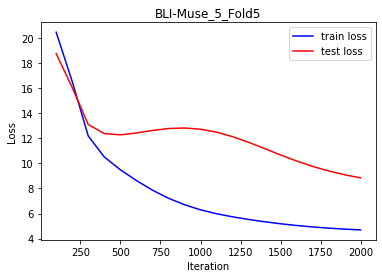

		rmse is 8.840239855415037.
********************
average rmse: 12.177396139418686
----------------------------------------
Vecmap
	Fold 1: 


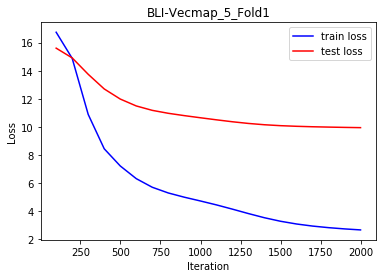

		rmse is 9.944496482115529.
********************
	Fold 2: 


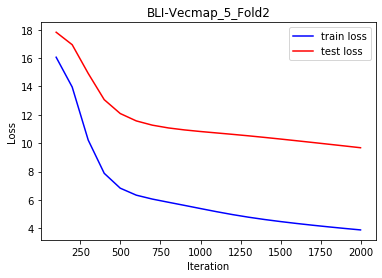

		rmse is 9.68133132311975.
********************
	Fold 3: 


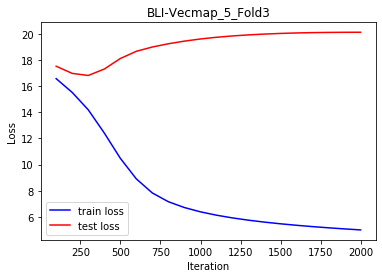

		rmse is 20.1187361040198.
********************
	Fold 4: 


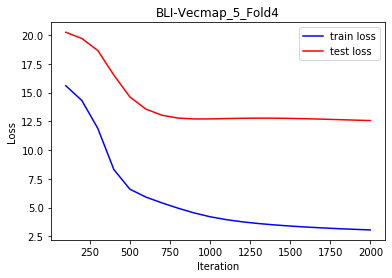

		rmse is 12.566984687386478.
********************
	Fold 5: 


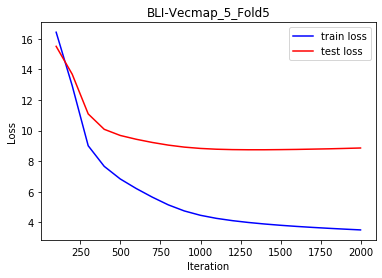

		rmse is 8.860809371722862.
********************
average rmse: 12.234471593672884
num running: 6
----------------------------------------
Muse
	Fold 1: 


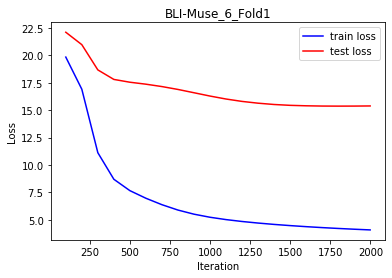

		rmse is 15.387032434802384.
********************
	Fold 2: 


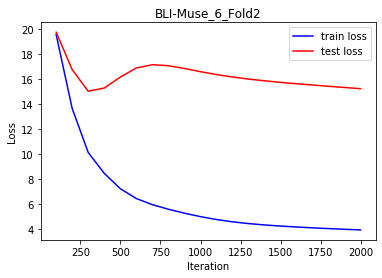

		rmse is 15.241701148563887.
********************
	Fold 3: 


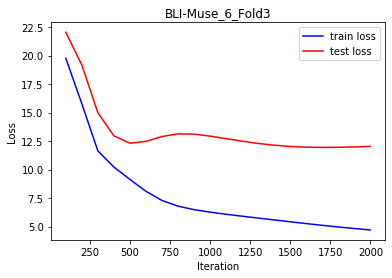

		rmse is 12.03455191421183.
********************
	Fold 4: 


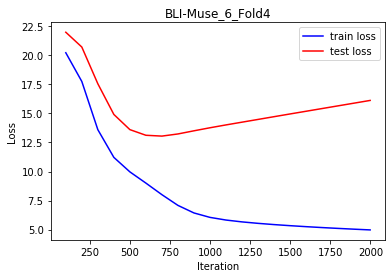

		rmse is 16.116296965874817.
********************
	Fold 5: 


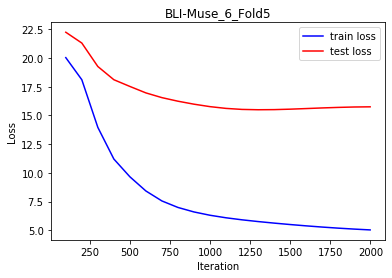

		rmse is 15.746340123104545.
********************
average rmse: 14.905184517311493
----------------------------------------
Vecmap
	Fold 1: 


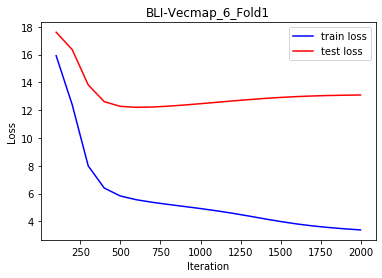

		rmse is 13.099146174364822.
********************
	Fold 2: 


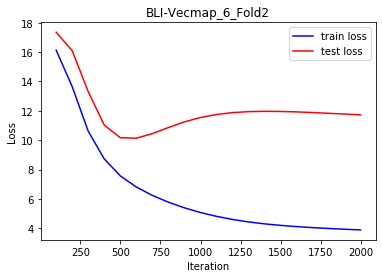

		rmse is 11.72863841870634.
********************
	Fold 3: 


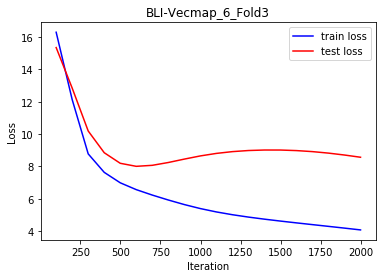

		rmse is 8.567682221577124.
********************
	Fold 4: 


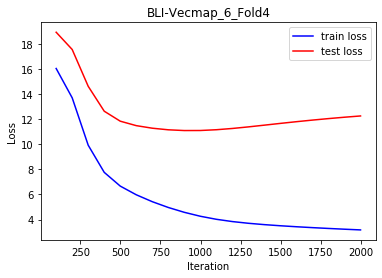

		rmse is 12.247774715024578.
********************
	Fold 5: 


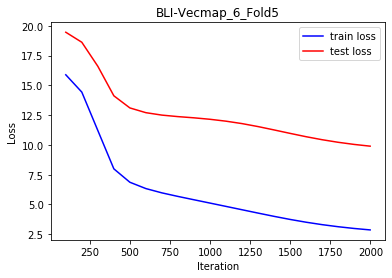

		rmse is 9.894489005021862.
********************
average rmse: 11.107546106938944
num running: 7
----------------------------------------
Muse
	Fold 1: 


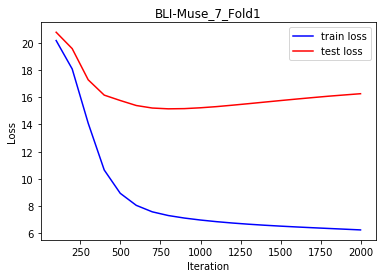

		rmse is 16.26055640083065.
********************
	Fold 2: 


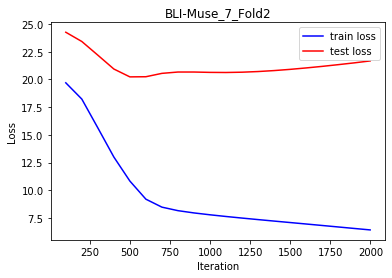

		rmse is 21.66952160197645.
********************
	Fold 3: 


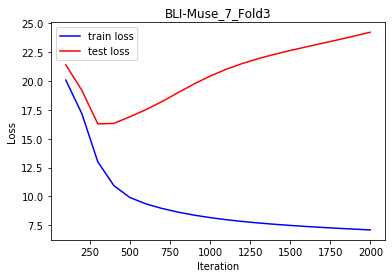

		rmse is 24.22634661955744.
********************
	Fold 4: 


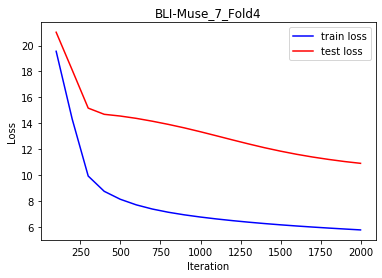

		rmse is 10.911099389519103.
********************
	Fold 5: 


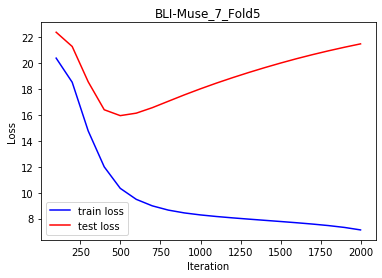

		rmse is 21.505045734898566.
********************
average rmse: 18.914513949356444
----------------------------------------
Vecmap
	Fold 1: 


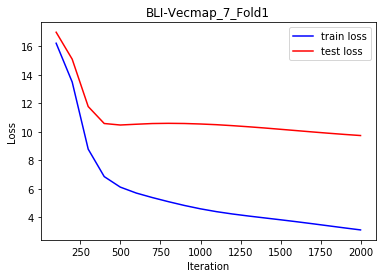

		rmse is 9.738863283349954.
********************
	Fold 2: 


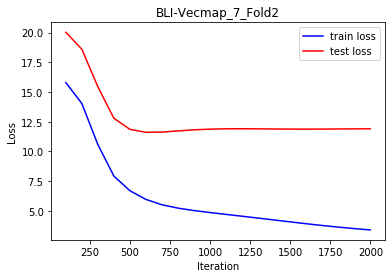

		rmse is 11.901453251769066.
********************
	Fold 3: 


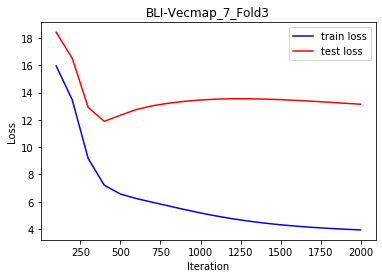

		rmse is 13.13973609206166.
********************
	Fold 4: 


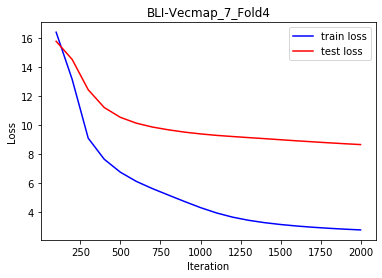

		rmse is 8.655178486325111.
********************
	Fold 5: 


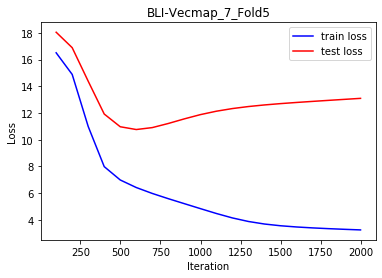

		rmse is 13.097577414685368.
********************
average rmse: 11.306561705638233
num running: 8
----------------------------------------
Muse
	Fold 1: 


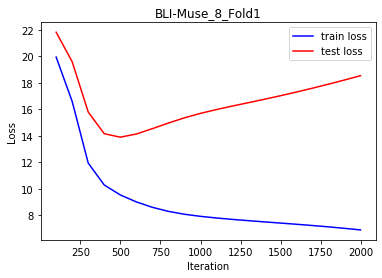

		rmse is 18.546166912227825.
********************
	Fold 2: 


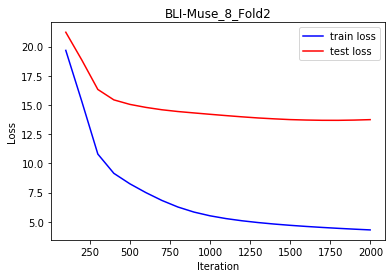

		rmse is 13.748275619662829.
********************
	Fold 3: 


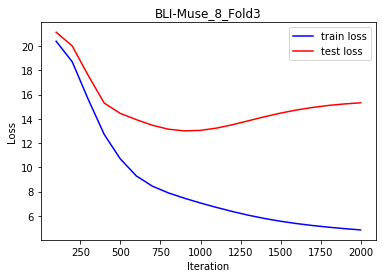

		rmse is 15.32030534751398.
********************
	Fold 4: 


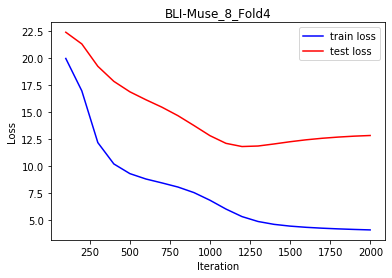

		rmse is 12.8416264650976.
********************
	Fold 5: 


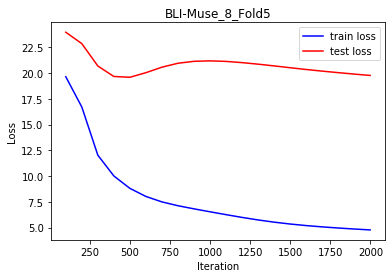

		rmse is 19.77746025632044.
********************
average rmse: 16.046766920164533
----------------------------------------
Vecmap
	Fold 1: 


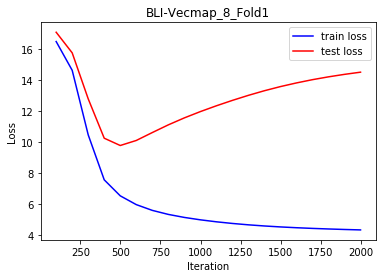

		rmse is 14.522737602229434.
********************
	Fold 2: 


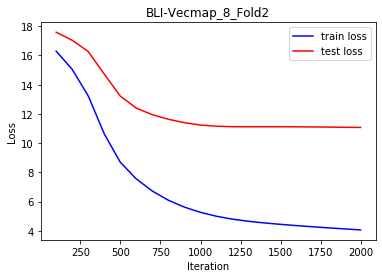

		rmse is 11.07343586896005.
********************
	Fold 3: 


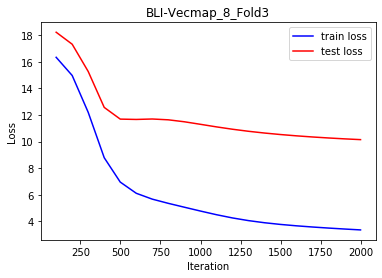

		rmse is 10.140968335459675.
********************
	Fold 4: 


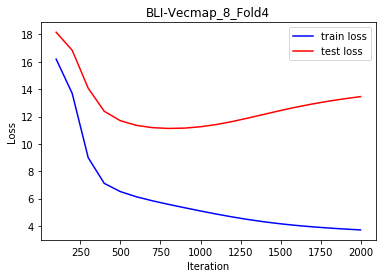

		rmse is 13.455454694572946.
********************
	Fold 5: 


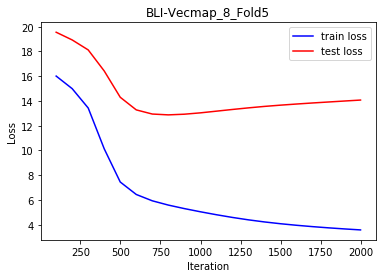

		rmse is 14.075753648620555.
********************
average rmse: 12.653670029968534
num running: 9
----------------------------------------
Muse
	Fold 1: 


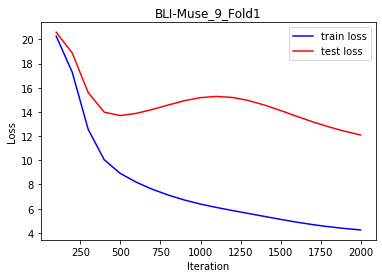

		rmse is 12.098638836010915.
********************
	Fold 2: 


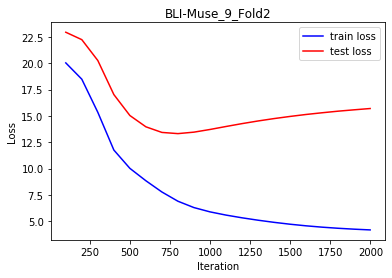

		rmse is 15.700315680614686.
********************
	Fold 3: 


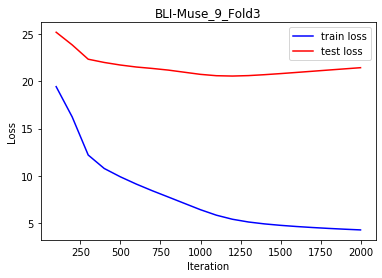

		rmse is 21.448722914016557.
********************
	Fold 4: 


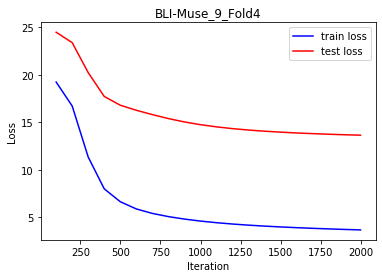

		rmse is 13.653466486886996.
********************
	Fold 5: 


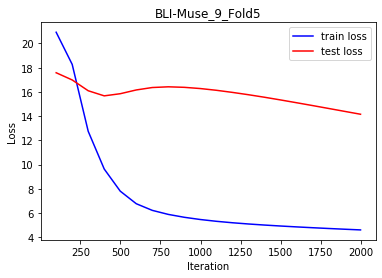

		rmse is 14.154069028621336.
********************
average rmse: 15.411042589230098
----------------------------------------
Vecmap
	Fold 1: 


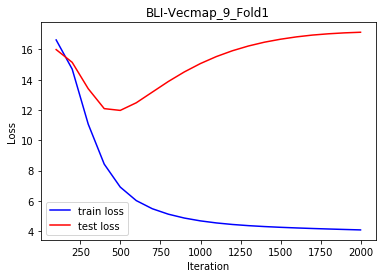

		rmse is 17.133389943377974.
********************
	Fold 2: 


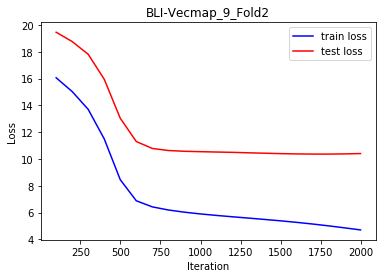

		rmse is 10.40664245387544.
********************
	Fold 3: 


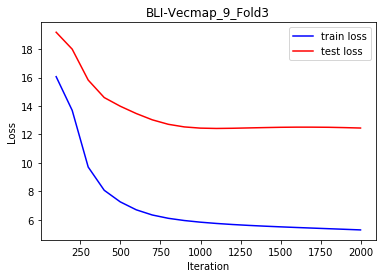

		rmse is 12.450718286195238.
********************
	Fold 4: 


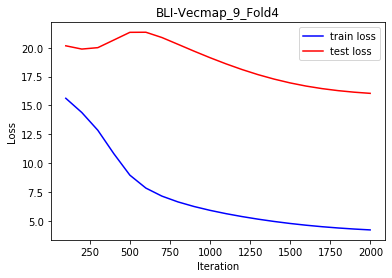

		rmse is 16.04646975147968.
********************
	Fold 5: 


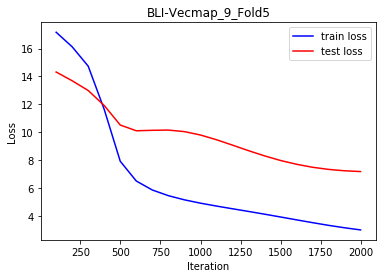

		rmse is 7.189777291779327.
********************
average rmse: 12.645399545341531
num running: 10
----------------------------------------
Muse
	Fold 1: 


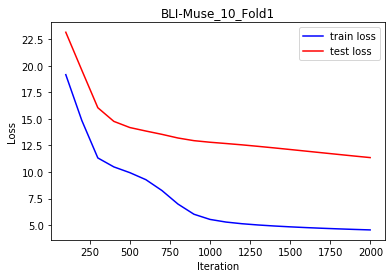

		rmse is 11.359524492002084.
********************
	Fold 2: 


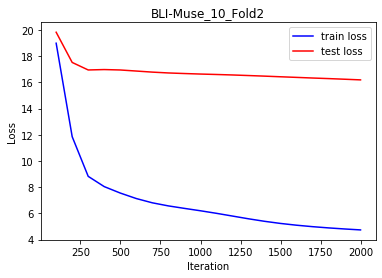

		rmse is 16.191328717718864.
********************
	Fold 3: 


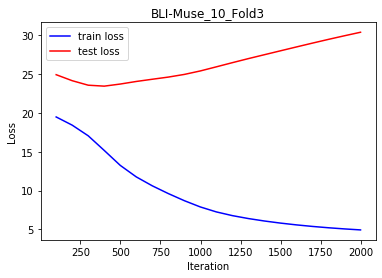

		rmse is 30.383300048115103.
********************
	Fold 4: 


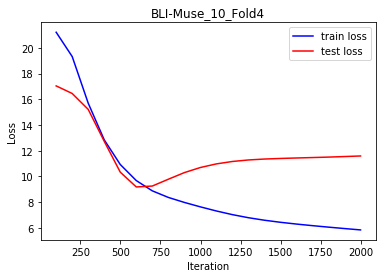

		rmse is 11.591313646747894.
********************
	Fold 5: 


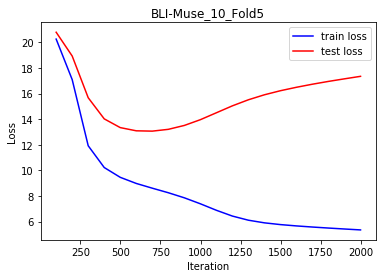

		rmse is 17.347445865007938.
********************
average rmse: 17.37458255391838
----------------------------------------
Vecmap
	Fold 1: 


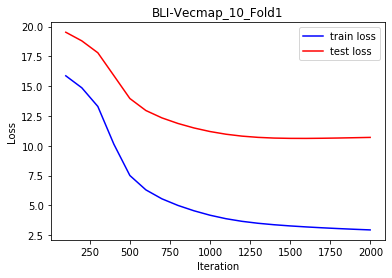

		rmse is 10.698546131273783.
********************
	Fold 2: 


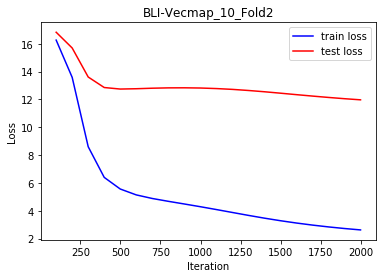

		rmse is 11.970766921653482.
********************
	Fold 3: 


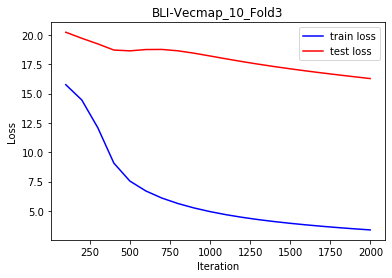

		rmse is 16.275395227764125.
********************
	Fold 4: 


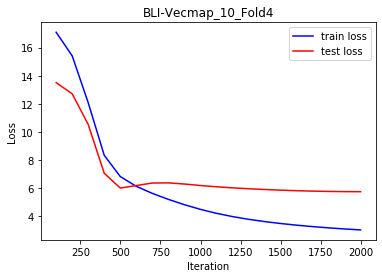

		rmse is 5.73858455752796.
********************
	Fold 5: 


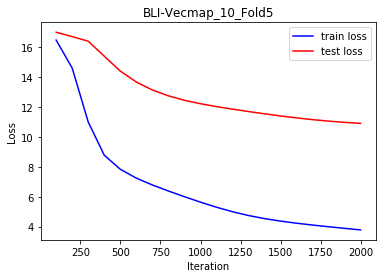

		rmse is 10.895403951160938.
********************
average rmse: 11.115739357876055


In [5]:
WIKI_MT_DIR = "../data/data_wiki_new.csv"
WIKI_SRC = "Source"
WIKI_TGT = "Target"
WIKI_SCORE = ["BLEU"]
WIKI_SIDE_FEATURES = ['geographic', 'genetic', 'inventory', 'syntactic', 'phonological', 'featural']
WIKI_ALPHA = 0.0001
WIKI_BETA = 0.1

BLI_DIR = "../data/data_bli2_new.csv"
BLI_SRC = "Source Language Code"
BLI_TGT = "Target Language Code"
BLI_SCORE = ["Muse", "Vecmap"]
BLI_SIDE_FEATURES = ['genetic', 'syntactic', 'featural', 'phonological', 'inventory', 'geographic']
BLI_ALPHA = 0.0001
BLI_BETA = 0.0005
# The score metric is from "NLPerf/src/task_feats.py"

k = 5
num_running = 10

WIKI_SIDE_INFO_DICT = get_language_pair_side_info(WIKI_MT_DIR, WIKI_SIDE_FEATURES, WIKI_SRC, WIKI_TGT)
WIKI_SRC_SIDE_INFO_DICT, WIKI_TGT_SIDE_INFO_DICT = get_language_side_information(WIKI_MT_DIR, WIKI_SRC, WIKI_TGT)

BLI_SIDE_INFO_DICT = get_language_pair_side_info(BLI_DIR, BLI_SIDE_FEATURES, BLI_SRC, BLI_TGT)
BLI_SRC_SIDE_INFO_DICT, BLI_TGT_SIDE_INFO_DICT = get_language_side_information(BLI_DIR, BLI_SRC, BLI_TGT)

wiki_result = get_result(WIKI_ALPHA, WIKI_BETA, WIKI_MT_DIR, WIKI_SCORE, WIKI_SRC, WIKI_TGT, k, num_running, \
                         src_lang_side_info=WIKI_SRC_SIDE_INFO_DICT, \
                         tgt_lang_side_info=WIKI_TGT_SIDE_INFO_DICT, \
                         src_si_len=6, tgt_si_len=6)
bli_result = get_result(BLI_ALPHA, BLI_BETA, BLI_DIR, BLI_SCORE, BLI_SRC, BLI_TGT, k, num_running, \
                         src_lang_side_info=BLI_SRC_SIDE_INFO_DICT, \
                         tgt_lang_side_info=BLI_TGT_SIDE_INFO_DICT, \
                         src_si_len=6, tgt_si_len=6)

# wiki_mt_score_matrix = generate_score_matrix(WIKI_MT_DIR, "Source", "Target", "BLEU")
# wiki_mt_score_matrix, wiki_mt_valid = generate_score_matrix(WIKI_MT_DIR, "Source", "Target", "BLEU")xdz
# bli_score_matrix, bli_valid = generate_score_matrix(BLI_DIR, "Source Language Code", "Target Language Code", ["Muse", "Vecmap"])

In [6]:
print(wiki_result)
print(bli_result)

3.3325223896125147
13.724772063771729
